In [1]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW# get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import time

from utils import *
from Custom_Dataset_Class import *
from BertFineTuned import *
from LongTerm import *

from BERT_Hierarchical import BERT_Hierarchical_Model

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Quadro T2000


# Fine Tunning of BERT for long texts

##### in this notebook we will Investigate Different Fine-Tuning Strategies for long texts and compare their results with those of RoBERT 

## Treat each chunk as a Document 

In [3]:
TRAIN_BATCH_SIZE=8
EPOCH=3
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=BertConsumerComplaints().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("\t§§ model has been saved §§")
    torch.save(model, f"model1/model_epoch{epoch+1}.pt")    

Loading BERT tokenizer...
Nettoyage des données

=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1715 (0.00%), loss = 2.1133, time = 7.87 secondes ___
___ batch index = 250 / 1715 (14.58%), loss = 0.9814, time = 2239.74 secondes ___
___ batch index = 500 / 1715 (29.15%), loss = 0.7243, time = 2250.50 secondes ___
___ batch index = 750 / 1715 (43.73%), loss = 0.7141, time = 2244.55 secondes ___
___ batch index = 1000 / 1715 (58.31%), loss = 0.7176, time = 2229.39 secondes ___
___ batch index = 1250 / 1715 (72.89%), loss = 0.6091, time = 2227.16 secondes ___
___ batch index = 1500 / 1715 (87.46%), loss = 0.6296, time = 2286.94 secondes ___

*** avg_loss : 0.74, time : ~256.0 min (15387.14 sec) ***

==> evaluation : avg_loss = 0.57, time : 1139.75 sec

=====>	{'accuracy': 0.8305219464806147, 'nb exemple': 11323, 'true_prediction': 9404, 'false_prediction': 1919}
	§§ model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1715 (0.00%),

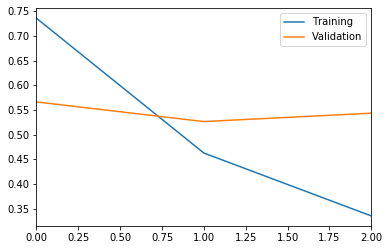

In [17]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

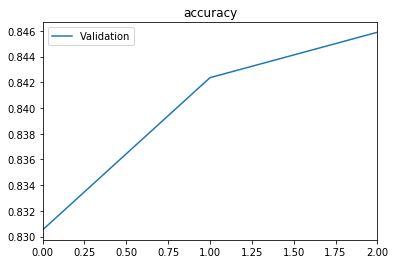

In [21]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

##### Now we will experience different strategies presented in this paper https://arxiv.org/pdf/1905.05583.pdf

such as:  
    * Tunction Method:  
        + Head only  
        + Tail only  
    * Hierarchical Method:  
        + Mean pooling  
        + Max pooling  


## Truncation Method

### Head only (keep only the first chunk) 

In [3]:
TRAIN_BATCH_SIZE=8
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

approach='head'

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN,
    approach=approach)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=BertConsumerComplaints().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ Truncation {approach} only model has been saved §§")
    torch.save(model, f"model_truncation/{approach}_only/model_{approach}_only_epoch{epoch+1}.pt")

Loading BERT tokenizer...
Nettoyage des données

=============== EPOCH 1 / 1 ===============

___ batch index = 0 / 1715 (0.00%), loss = 2.3635, time = 3.18 secondes ___
___ batch index = 250 / 1715 (14.58%), loss = 0.5998, time = 731.99 secondes ___
___ batch index = 500 / 1715 (29.15%), loss = 0.7589, time = 735.60 secondes ___
___ batch index = 750 / 1715 (43.73%), loss = 0.4989, time = 728.82 secondes ___
___ batch index = 1000 / 1715 (58.31%), loss = 0.3450, time = 777.80 secondes ___
___ batch index = 1250 / 1715 (72.89%), loss = 0.3121, time = 752.25 secondes ___
___ batch index = 1500 / 1715 (87.46%), loss = 0.4961, time = 735.28 secondes ___

*** avg_loss : 0.62, time : ~85.0 min (5105.59 sec) ***

==> evaluation : avg_loss = 0.45, time : 373.05 sec

=====>	{'accuracy': 0.8661026837806302, 'nb exemple': 3428, 'true_prediction': 2969, 'false_prediction': 459}
	§§ Truncation head only model has been saved §§


### Tail only (keep only the last chunk)

In [4]:
TRAIN_BATCH_SIZE=8
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000
approach='tail'

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN,
    approach=approach)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=BertConsumerComplaints().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ Truncation {approach} only model has been saved §§")
    torch.save(model, f"model_truncation/{approach}_only/model_{approach}_only_epoch{epoch+1}.pt")

Loading BERT tokenizer...
Nettoyage des données

=============== EPOCH 1 / 1 ===============

___ batch index = 0 / 1715 (0.00%), loss = 2.1509, time = 3.13 secondes ___
___ batch index = 250 / 1715 (14.58%), loss = 1.2897, time = 722.46 secondes ___
___ batch index = 500 / 1715 (29.15%), loss = 0.8756, time = 717.34 secondes ___
___ batch index = 750 / 1715 (43.73%), loss = 0.8291, time = 735.28 secondes ___
___ batch index = 1000 / 1715 (58.31%), loss = 0.9937, time = 730.64 secondes ___
___ batch index = 1250 / 1715 (72.89%), loss = 0.8284, time = 721.17 secondes ___
___ batch index = 1500 / 1715 (87.46%), loss = 0.7413, time = 812.83 secondes ___

*** avg_loss : 0.93, time : ~85.0 min (5158.26 sec) ***

==> evaluation : avg_loss = 0.75, time : 378.74 sec

=====>	{'accuracy': 0.7669194865810969, 'nb exemple': 3428, 'true_prediction': 2629, 'false_prediction': 799}
	§§ Truncation tail only model has been saved §§


## Hierarchical Method

### Mean Pooling 

In [ ]:
TRAIN_BATCH_SIZE=3
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="mean"
model_hierarchical=BERT_Hierarchical_Model(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")
    torch.save(model_hierarchical, f"model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")    

Loading BERT tokenizer...
Nettoyage des données

=============== EPOCH 1 / 1 ===============

___ batch index = 0 / 4572 (0.00%), loss = 2.6007, time = 3.68 secondes ___
___ batch index = 640 / 4572 (14.00%), loss = 0.7968, time = 2263.71 secondes ___
___ batch index = 1280 / 4572 (28.00%), loss = 0.5498, time = 2324.65 secondes ___
___ batch index = 1920 / 4572 (41.99%), loss = 0.6785, time = 2353.31 secondes ___
___ batch index = 2560 / 4572 (55.99%), loss = 0.4982, time = 2294.36 secondes ___
___ batch index = 3200 / 4572 (69.99%), loss = 0.4953, time = 2243.18 secondes ___
___ batch index = 3840 / 4572 (83.99%), loss = 0.3333, time = 2279.44 secondes ___


### Max Pooling 

In [ ]:
TRAIN_BATCH_SIZE=3
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="max"
model_hierarchical=BERT_Hierarchical_Model(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")
    torch.save(model_hierarchical, f"model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")    

# RoBERT RNN classifier on top of the Fine Tuned Bert Model

https://arxiv.org/pdf/1910.10781.pdf

In [2]:
TRAIN_BATCH_SIZE=3
EPOCH=3
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=torch.load("model1/model_epoch2.pt")

model_rnn=LongTermModel(bertFineTuned=list(model.children())[0]).to(device)
optimizer=AdamW(model_rnn.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_rnn, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_rnn, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("\t§§ the RNN model has been saved §§")
    torch.save(model_rnn, f"model_rnn1/model_rnn_epoch{epoch+1}.pt")    

Loading BERT tokenizer...
Nettoyage des données

=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 4572 (0.00%), loss = 2.2945, time = 2.84 secondes ___
___ batch index = 640 / 4572 (14.00%), loss = 0.5428, time = 2183.01 secondes ___
___ batch index = 1280 / 4572 (28.00%), loss = 0.5160, time = 2271.89 secondes ___
___ batch index = 1920 / 4572 (41.99%), loss = 0.3916, time = 2397.69 secondes ___
___ batch index = 2560 / 4572 (55.99%), loss = 0.3850, time = 2242.30 secondes ___
___ batch index = 3200 / 4572 (69.99%), loss = 0.5946, time = 2209.33 secondes ___
___ batch index = 3840 / 4572 (83.99%), loss = 0.1687, time = 2334.60 secondes ___
___ batch index = 4480 / 4572 (97.99%), loss = 0.3264, time = 2229.14 secondes ___

*** avg_loss : 0.46, time : ~269.0 min (16172.74 sec) ***

==> evaluation : avg_loss = 0.34, time : 1112.53 sec

=====>	{'accuracy': 0.911318553092182, 'nb exemple': 3428, 'true_prediction': 3124, 'false_prediction': 304}
	§§ the RNN model has been 

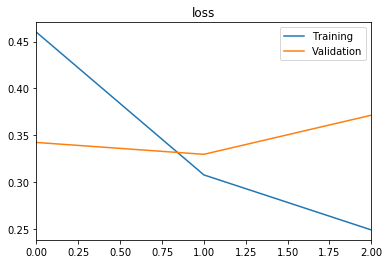

In [3]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

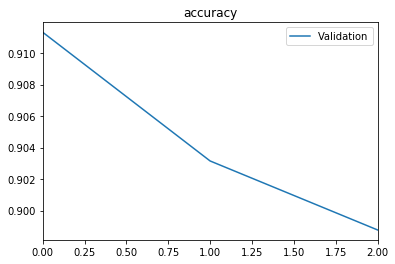

In [6]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")